# Analyse Niedrigwassertage

Als Niedrigwasser definieren wir alle Werte, die unter dem 1. Quantil liegen, <br>
also alle Werte, die in 90% der Fälle übertroffen werden. <br>
Da der Bias der Modell bei niedrigen Werten nicht korrigiert wurde, <br> 
sollte das 1. Quantil nicht aus den beobachteten Werten, sondern muss aus den Modelloutput berechnet werden. <br>
Als Referenzperiode dafür wird der Zeitraum 2006 bis 2023 verwendet, <br>
wie auch schon bei der Biaskorrektur der ReKlies Temperatur- und Niederschlagsdaten <br>
und dem Test des Deep-Learning-Modells. <br>
Durch den relativ kurzen Zeitraum wird verhindert, dass der Wert des 1. Quantils durch Effekte des Klimawandels verzerrt wird.

In [25]:
# benötige packages laden und working direction setzen

import os
import pandas as pd
import matplotlib.pyplot as plt 

# benötige Datensätze laden

historic = pd.read_csv("https://raw.githubusercontent.com/emorl/projektstudie-murgtal/main/1_daten/era5_tas_prec_discharge_merge.csv")
historic['date'] = pd.to_datetime(historic['date'])

rcp26 = pd.read_csv("https://raw.githubusercontent.com/emorl/projektstudie-murgtal/main/1_daten/rcp26_flow_predicted.csv")
rcp26['date'] = pd.to_datetime(rcp26['date'], format='%d/%m/%Y')

rcp85 = pd.read_csv("https://raw.githubusercontent.com/emorl/projektstudie-murgtal/main/1_daten/rcp85_flow_predicted.csv")
rcp85['date'] = pd.to_datetime(rcp85['date'], format='%d/%m/%Y')

In [26]:
# Referenzperiode Q1 berechnen
q1_ref = historic['flow_m3_s'].quantile(q=0.1)

# RCP2.6 Q1 Referenz
q1_rcp26 = rcp26.loc[
    (rcp26['date'] >= '2006-01-01') &
    (rcp26['date'] <= '2024-12-31'), 
    'predicted_flow_m3_s'].quantile(0.1)

# RCP8.5 Q1 Referenz
q1_rcp85 = rcp85.loc[
    (rcp85['date'] >= '2006-01-01') &
    (rcp85['date'] <= '2024-12-31'), 
    'predicted_flow_m3_s'].quantile(0.1)

In [27]:
# markieren ob Wert unterhalb Q1 liegt (True/False)
historic['low_flow'] = historic['flow_m3_s'] < q1_ref
rcp26['low_flow'] = rcp26['predicted_flow_m3_s'] < q1_rcp26
rcp85['low_flow'] = rcp85['predicted_flow_m3_s'] < q1_rcp85

# Niederigwassertage/Jahr smoothed

Aus den fast 100 Datenpunkten (Jahre) lässt sich schwer ein Trend erkennen. <br>
Zur besseren Visualisierung werden die Daten mit dem LOWESS-Verfahren geglättet. <br>
Es wird also für jeden Datenpunkt das Mittel aus einigen Datenpunkten davor und danach gebildet.

In [28]:
# package installieren, falls nötig
# pip install statsmodels

In [29]:
# benötigte Pakete
from statsmodels.nonparametric.smoothers_lowess import lowess
from datetime import datetime

In [30]:
# Funktion zur Berechnung der Niedrigwassertage und LOWESS-Trends

def calculate_lowess_lowflow(df, frac=0.1):
    
    # alle Jahren listen, dass auch Jahre ohne Niedrigwasser berücksichtigt werden
    years = range(2006,2099)
    
    # Anzahl der Niedrigwassertage/Jahr zählen
    low_flow_counts = ( 
        df[df['low_flow']] # in Datensatz, auf den Funktion angewandt wird, in Spalte "low_flow" "True" filtern
            .groupby(df[df['low_flow']]['date'].dt.year) # nach Jahr gruppieren
            .size() # Anzahl der Reihen/Tage
            .reindex(years, fill_value=0) # Index neustarten
    )
    
    # x = Zeit , LOWESS erwartet numerische Zahlen (kein Datum), umwandeln, x ist jetzt die Anzahl Tage seit 01.01.0001
    x = low_flow_counts.index.to_series().map(lambda year: datetime(year, 1, 1).toordinal())
    y = low_flow_counts.values # y = Anzahl Tage/Jahr

    # LOWESS berechnen
    # frac = Anteil der Datenpunkte, die für die Glättung verwendet werden, je höher der Wert, desto glatter der Trend
    lowess_result = lowess(y, x, frac=frac) # fraction

    # zurück in datetime year umwandeln für Plot
    x_trend = [datetime.fromordinal(int(val)).year for val in lowess_result[:, 0]]
    y_trend = lowess_result[:, 1]
    
    return low_flow_counts.index, low_flow_counts.values, x_trend, y_trend

In [31]:
# auf die Datensätze anwenden

# x_*_raw = Jahreszahl
# y_*_raw = Anzahl der Niedrigwassertage -> nicht geglättet
# x_*_trend = Jahreszahl für LOWESS-Trend
# y_*_trend = Anzahl der Niedrigwassertage -> LOWESS-geglätt
x_26_raw_1, y_26_raw_1, x_26_trend_1, y_26_trend_1 = calculate_lowess_lowflow(rcp26, frac=0.1)
x_85_raw_1, y_85_raw_1, x_85_trend_1, y_85_trend_1 = calculate_lowess_lowflow(rcp85, frac=0.1)

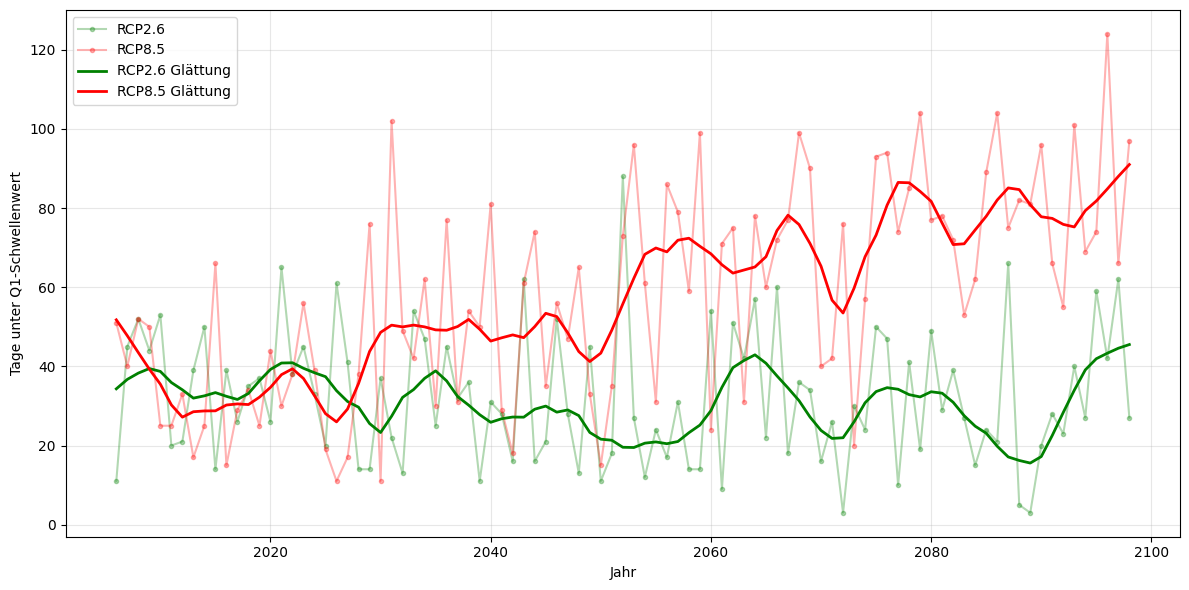

In [32]:
# plotten

plt.figure(figsize=(12, 6))

# Rohdaten
plt.plot(x_26_raw_1, y_26_raw_1, label='RCP2.6', alpha=0.3, marker='o', markersize=3, color="green")
plt.plot(x_85_raw_1, y_85_raw_1, label='RCP8.5', alpha=0.3, marker='o', markersize=3, color="red")

# LOWESS trends
plt.plot(x_26_trend_1, y_26_trend_1, label='RCP2.6 Glättung', linewidth=2, color="green")
plt.plot(x_85_trend_1, y_85_trend_1, label='RCP8.5 Glättung', linewidth=2, color="red")

plt.xlabel('Jahr')
plt.ylabel('Tage unter Q1-Schwellenwert')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [33]:
# Tabellenwerte berechnen
# Mittelwert, Standardabweichung, Min, Max

# Referenzzeiträume bestimmten
rcp26_mid_1 = y_26_raw_1[(x_26_raw_1 >= 2021) & (x_26_raw_1 <= 2050)]
rcp85_mid_1 = y_85_raw_1[(x_85_raw_1 >= 2021) & (x_85_raw_1 <= 2050)]
rcp26_end_1 = y_26_raw_1[(x_26_raw_1 >= 2071) & (x_26_raw_1 <= 2099)]
rcp85_end_1 = y_85_raw_1[(x_85_raw_1 >= 2071) & (x_85_raw_1 <= 2099)]

print("Period 2021-2050:")
print(f"RCP2.6 mid future: Mean: {rcp26_mid_1.mean():.2f},  Std: {rcp26_mid_1.std():.2f}, Min: {rcp26_mid_1.min()}, Max: {rcp26_mid_1.max()}")
print(f"RCP8.5 mid future: Mean: {rcp85_mid_1.mean():.2f},  Std: {rcp85_mid_1.std():.2f}, Min: {rcp85_mid_1.min()}, Max: {rcp85_mid_1.max()}")

print("\nPeriod 2071-2099:")
print(f"RCP2.6 end of century: Mean: {rcp26_end_1.mean():.2f},  Std: {rcp26_end_1.std():.2f}, Min: {rcp26_end_1.min()}, Max: {rcp26_end_1.max()}")
print(f"RCP8.5 end of century: Mean: {rcp85_end_1.mean():.2f},  Std: {rcp85_end_1.std():.2f}, Min: {rcp85_end_1.min()}, Max: {rcp85_end_1.max()}")

Period 2021-2050:
RCP2.6 mid future: Mean: 32.53,  Std: 16.13, Min: 11, Max: 65
RCP8.5 mid future: Mean: 44.87,  Std: 22.64, Min: 11, Max: 102

Period 2071-2099:
RCP2.6 end of century: Mean: 30.57,  Std: 16.72, Min: 3, Max: 66
RCP8.5 end of century: Mean: 77.36,  Std: 20.97, Min: 20, Max: 124


# Niedrigwasserereignisse/Jahr geglättet

Als Niedrigwasserereignis definieren wir mindestens 3 konsekutive Tage die unter dem Schwellenwert des 1. Quantils liegen.

In [34]:
# Funktion zur Berechnung der Niedrigwasserereignisse und LOWESS-Trends

def low_flow_events(df, scenario_name):

    # nach Datum sortieren
    df = df.sort_values('date').reset_index(drop=True)
    
    # Events zählen jedes mal wenn high_flow wechselt (True/False)
    df['low_flow_group'] = (df['low_flow'] != df['low_flow'].shift()).cumsum()
    
    # high_flow = True Gruppen filtern 
    low_flow_periods = df[df['low_flow'] == True].groupby('low_flow_group').agg(
        start_date=('date', 'min'),
        end_date=('date', 'max'),
        duration=('date', 'count')
    ).reset_index(drop=True)
    
    # Events mit mind. 3 Tagen filtern
    low_flow_events_df = low_flow_periods[low_flow_periods['duration'] >= 3].copy()
    
    # ID und Jahr hinzufügen
    low_flow_events_df['id'] = range(1, len(low_flow_events_df) + 1)
    low_flow_events_df['year'] = low_flow_events_df['start_date'].dt.year
    
    # dataframe neu anordnen
    low_flow_events_df = low_flow_events_df[['id', 'year', 'start_date', 'end_date', 'duration']]
    
    # range definieren, dass auch Jahre ohne Ereignisse berücksichtigt werden
    years = range(2006,2099)
    
    # Anzahl der Events/Jahr
    events_per_year = (
        low_flow_events_df.groupby('year')
        .size()
        .reindex(years, fill_value=0)
    )
    
    # x = Zeit , LOWESS erwartet numerische Zahlen (kein Datum), umwandeln, x ist jetzt die Anzahl Tage seit 01.01.0001
    x = events_per_year.index.to_series().map(lambda year: datetime(year, 1, 1).toordinal())
    y = events_per_year.values
    
    # LOWESS berechnen
    lowess_result = lowess(y, x, frac=0.1)
    x_trend = [datetime.fromordinal(int(val)).year for val in lowess_result[:, 0]]
    y_trend = lowess_result[:, 1]
    
    # gibt DataFrame der Niedrigwasserereignisse und LOWESS-Trend für Plot zurück
    return low_flow_events_df, events_per_year.index, events_per_year.values, x_trend, y_trend

In [35]:
# auf Datensätze anwenden
rcp26_events, x_26_raw_2, y_26_raw_2, x_26_trend_2, y_26_trend_2 = low_flow_events(rcp26, 'rcp26')
rcp85_events, x_85_raw_2, y_85_raw_2, x_85_trend_2, y_85_trend_2 = low_flow_events(rcp85, 'rcp85')

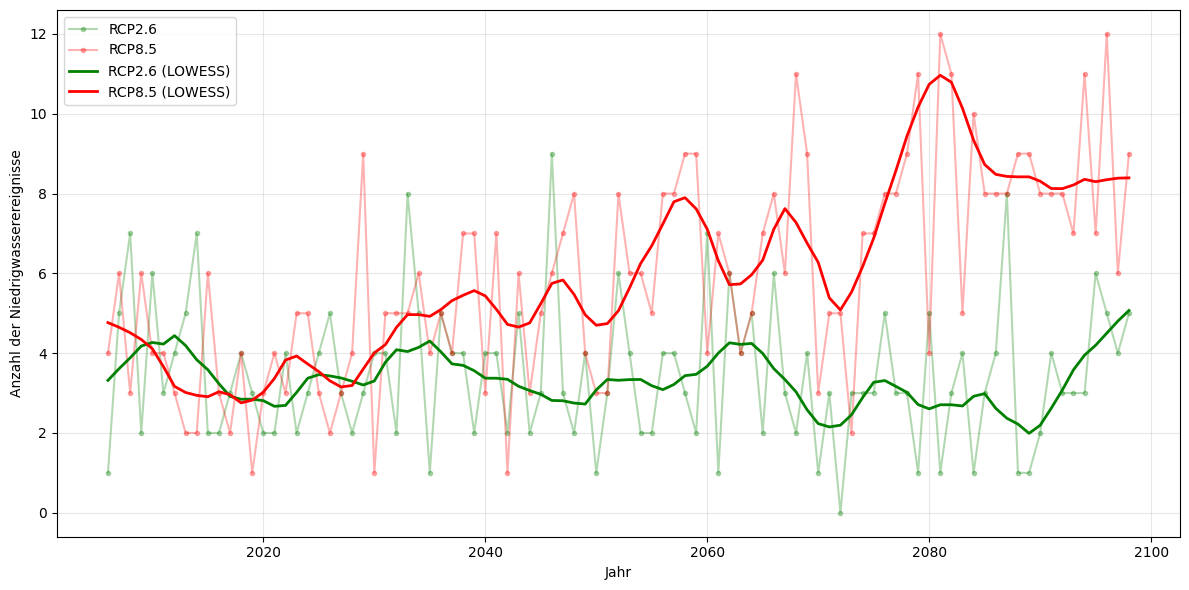

In [36]:
# plotten

plt.figure(figsize=(12, 6))

# Rohdaten
plt.plot(x_26_raw_2, y_26_raw_2, label='RCP2.6', alpha=0.3, marker='o', markersize=3, color="green")
plt.plot(x_85_raw_2, y_85_raw_2, label='RCP8.5', alpha=0.3, marker='o', markersize=3, color="red")

# LOWESS-Trend
plt.plot(x_26_trend_2, y_26_trend_2, label='RCP2.6 (LOWESS)', linewidth=2, color="green")
plt.plot(x_85_trend_2, y_85_trend_2, label='RCP8.5 (LOWESS)', linewidth=2, color="red")

plt.xlabel('Jahr')
plt.ylabel('Anzahl der Niedrigwasserereignisse')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [37]:
# Tabellenwerte berechnen

# Referenzzeiträume bestimmten
rcp26_mid_2 = y_26_raw_2[(x_26_raw_2 >= 2021) & (x_26_raw_2 <= 2050)]
rcp85_mid_2 = y_85_raw_2[(x_85_raw_2 >= 2021) & (x_85_raw_2 <= 2050)]
rcp26_end_2 = y_26_raw_2[(x_26_raw_2 >= 2071) & (x_26_raw_2 <= 2099)]
rcp85_end_2 = y_85_raw_2[(x_85_raw_2 >= 2071) & (x_85_raw_2 <= 2099)]

print("Period 2021-2050:")
print(f"RCP2.6 mid future: Mean: {rcp26_mid_2.mean():.2f}, Std: {rcp26_mid_2.std():.2f}, Min: {rcp26_mid_2.min()}, Max: {rcp26_mid_2.max()}")
print(f"RCP8.5 mid future: Mean: {rcp85_mid_2.mean():.2f}, Std: {rcp85_mid_2.std():.2f}, Min: {rcp85_mid_2.min()}, Max: {rcp85_mid_2.max()}")
print("\nPeriod 2071-2099:")
print(f"RCP2.6 end of century: Mean: {rcp26_end_2.mean():.2f}, Std: {rcp26_end_2.std():.2f}, Min: {rcp26_end_2.min()}, Max: {rcp26_end_2.max()}")
print(f"RCP8.5 end of century: Mean: {rcp85_end_2.mean():.2f}, Std: {rcp85_end_2.std():.2f}, Min: {rcp85_end_2.min()}, Max: {rcp85_end_2.max()}")

Period 2021-2050:
RCP2.6 mid future: Mean: 3.53, Std: 1.77, Min: 1, Max: 9
RCP8.5 mid future: Mean: 4.67, Std: 1.92, Min: 1, Max: 9

Period 2071-2099:
RCP2.6 end of century: Mean: 3.21, Std: 1.72, Min: 0, Max: 8
RCP8.5 end of century: Mean: 7.93, Std: 2.34, Min: 2, Max: 12


# Länge der Niedrigwasserereignisse

In [38]:
# Funktion zur Berechnung der Dauer der Niedrigwasserereignisse inkl. LOWESS Glättung
# Folgt dem gleichen Prinzip wie die vorherigen Funktionen

def low_flow_events_with_duration_smoothing(df, scenario_name, frac=0.1):

    # Same event extraction as before
    df = df.sort_values('date').reset_index(drop=True)
    df['low_flow_group'] = (df['low_flow'] != df['low_flow'].shift()).cumsum()
    
    low_flow_periods = df[df['low_flow'] == True].groupby('low_flow_group').agg(
        start_date=('date', 'min'),
        end_date=('date', 'max'),
        duration=('date', 'count')
    ).reset_index(drop=True)
    
    low_flow_events_df = low_flow_periods[low_flow_periods['duration'] >= 3].copy()
    low_flow_events_df['id'] = range(1, len(low_flow_events_df) + 1)
    low_flow_events_df['year'] = low_flow_events_df['start_date'].dt.year
    low_flow_events_df = low_flow_events_df[['id', 'year', 'start_date', 'end_date', 'duration']]
    
    # Get year range
    years = range(df['date'].dt.year.min(), df['date'].dt.year.max() + 1)
    
    # --- Events per year ---
    events_per_year = (
        low_flow_events_df.groupby('year')
        .size()
        .reindex(years, fill_value=0)
    )
    
    x_events = events_per_year.index.to_series().map(lambda y: datetime(y, 1, 1).toordinal())
    lowess_events = lowess(events_per_year.values, x_events, frac=frac)
    x_events_trend = [datetime.fromordinal(int(v)).year for v in lowess_events[:, 0]]
    y_events_trend = lowess_events[:, 1]
    
    # --- Average duration per year ---
    avg_duration = (
        low_flow_events_df.groupby('year')['duration']
        .mean()
        .reindex(years, fill_value=0)
    )
    
    x_duration = avg_duration.index.to_series().map(lambda y: datetime(y, 1, 1).toordinal())
    lowess_duration = lowess(avg_duration.values, x_duration, frac=frac)
    x_duration_trend = [datetime.fromordinal(int(v)).year for v in lowess_duration[:, 0]]
    y_duration_trend = lowess_duration[:, 1]
    
    return (low_flow_events_df, 
            avg_duration.index, avg_duration.values, x_duration_trend, y_duration_trend)

In [39]:
# auf Datensätze anwenden
(hist_events, x_hist_dur_raw, y_hist_dur_raw, x_hist_dur_trend, y_hist_dur_trend) = low_flow_events_with_duration_smoothing(historic, 'historic')
(rcp26_events, x_26_dur_raw, y_26_dur_raw, x_26_dur_trend, y_26_dur_trend) = low_flow_events_with_duration_smoothing(rcp26, 'rcp26')
(rcp85_events, x_85_dur_raw, y_85_dur_raw, x_85_dur_trend, y_85_dur_trend) = low_flow_events_with_duration_smoothing(rcp85, 'rcp85')

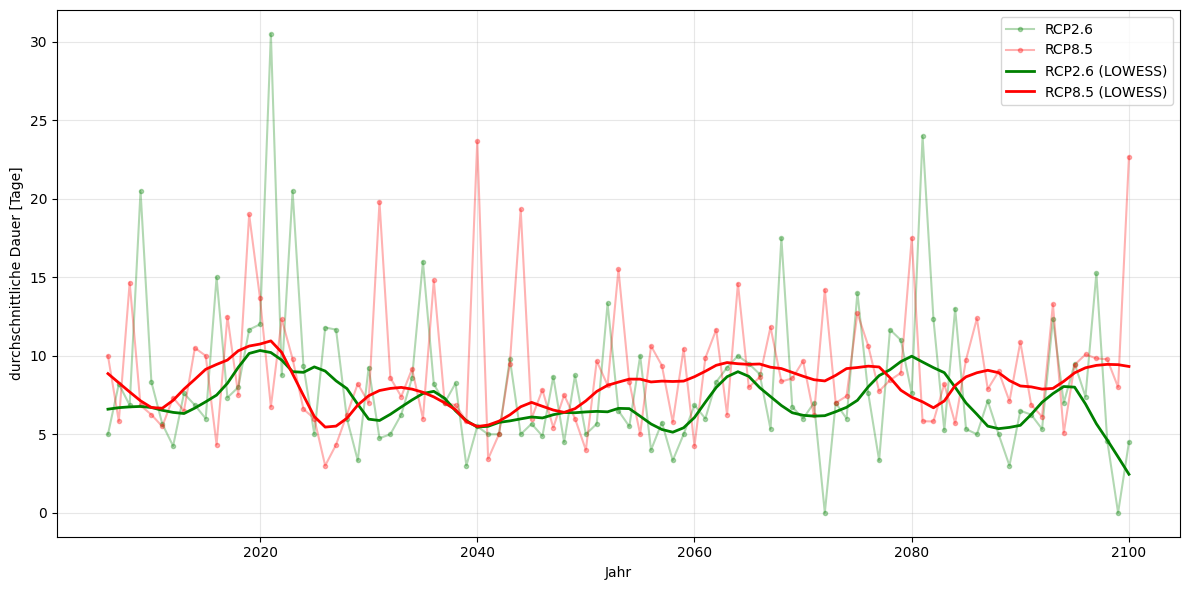

In [40]:
plt.figure(figsize=(12, 6))

plt.plot(x_26_dur_raw, y_26_dur_raw, alpha=0.3, marker='o', markersize=3, label='RCP2.6', color="green")
plt.plot(x_85_dur_raw, y_85_dur_raw, alpha=0.3, marker='o', markersize=3, label='RCP8.5', color="red")

plt.plot(x_26_dur_trend, y_26_dur_trend, linewidth=2, label='RCP2.6 (LOWESS)', color="green")
plt.plot(x_85_dur_trend, y_85_dur_trend, linewidth=2, label='RCP8.5 (LOWESS)', color="red")

plt.xlabel('Jahr')
plt.ylabel('durchschnittliche Dauer [Tage]')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [41]:
# Tabellenwerte berechnen

# Referenzzeiträume bestimmten
rcp26_mid_2 = y_26_dur_raw[(x_26_dur_raw >= 2021) & (x_26_dur_raw <= 2050)]
rcp85_mid_2 = y_85_dur_raw[(x_85_dur_raw >= 2021) & (x_85_dur_raw <= 2050)]
rcp26_end_2 = y_26_dur_raw[(x_26_dur_raw >= 2071) & (x_26_dur_raw <= 2099)]
rcp85_end_2 = y_85_dur_raw[(x_85_dur_raw >= 2071) & (x_85_dur_raw <= 2099)]

print("Period 2021-2050:")
print(f"RCP2.6 mid future: Mean: {rcp26_mid_2.mean():.2f}, Std: {rcp26_mid_2.std():.2f}, Min: {rcp26_mid_2.min()}, Max: {rcp26_mid_2.max()}")
print(f"RCP8.5 mid future: Mean: {rcp85_mid_2.mean():.2f}, Std: {rcp85_mid_2.std():.2f}, Min: {rcp85_mid_2.min()}, Max: {rcp85_mid_2.max()}")
print("\nPeriod 2071-2099:")
print(f"RCP2.6 end of century: Mean: {rcp26_end_2.mean():.2f}, Std: {rcp26_end_2.std():.2f}, Min: {rcp26_end_2.min()}, Max: {rcp26_end_2.max()}")
print(f"RCP8.5 end of century: Mean: {rcp85_end_2.mean():.2f}, Std: {rcp85_end_2.std():.2f}, Min: {rcp85_end_2.min()}, Max: {rcp85_end_2.max()}")

Period 2021-2050:
RCP2.6 mid future: Mean: 8.37, Std: 5.51, Min: 3.0, Max: 30.5
RCP8.5 mid future: Mean: 8.45, Std: 4.84, Min: 3.0, Max: 23.666666666666668

Period 2071-2099:
RCP2.6 end of century: Mean: 7.91, Std: 4.81, Min: 0.0, Max: 24.0
RCP8.5 end of century: Mean: 9.03, Std: 2.84, Min: 5.090909090909091, Max: 17.5
